## Australia Home Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data Understanding, Preparation, cleaning and EDA
- Model Building and Evaluation 

### 1. Data Understanding, Preparation, Cleaning and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [263]:
# reading the dataset
home_df = pd.read_csv("train.csv")

In [264]:
home_df.shape

(1460, 81)

In [265]:
# summary of the dataset: 1460 rows, 81 columns, no null values
print(home_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### VIsualizing Data

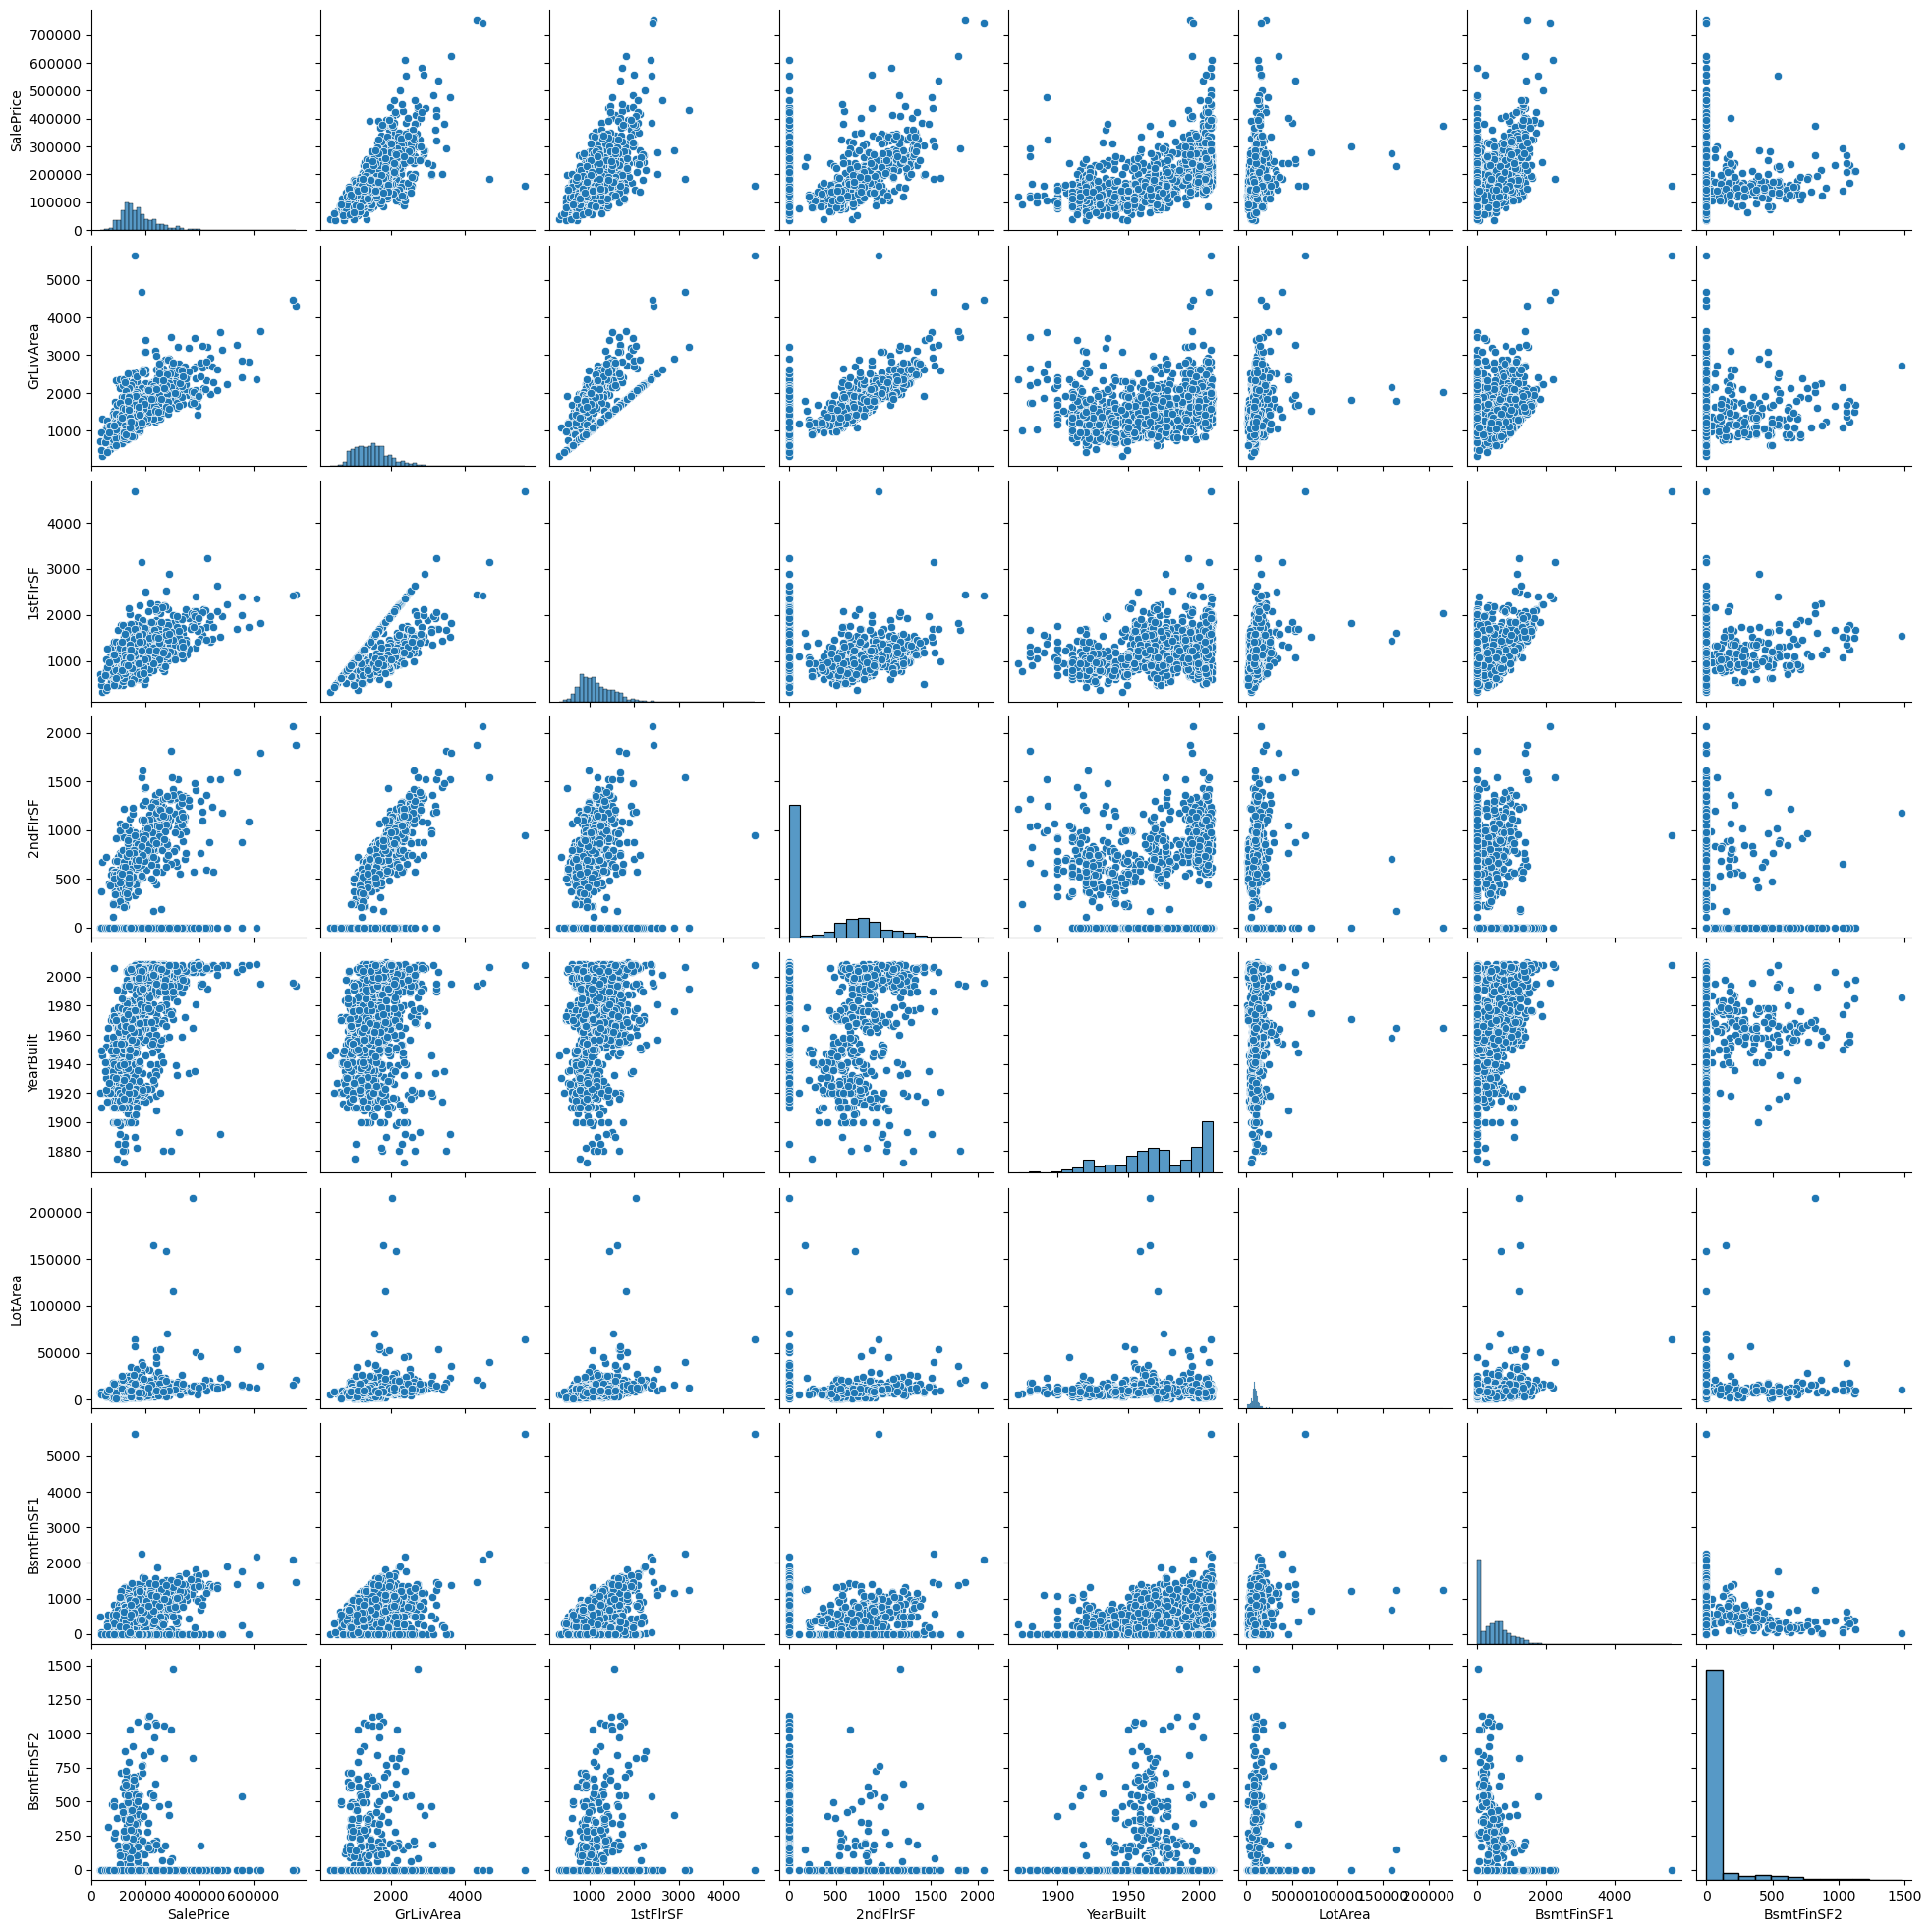

In [287]:
#Visualising Numeric Variables
sns.pairplot(home_df[['SalePrice','GrLivArea','1stFlrSF','2ndFlrSF','YearBuilt','LotArea','BsmtFinSF1','BsmtFinSF2']])
plt.show()

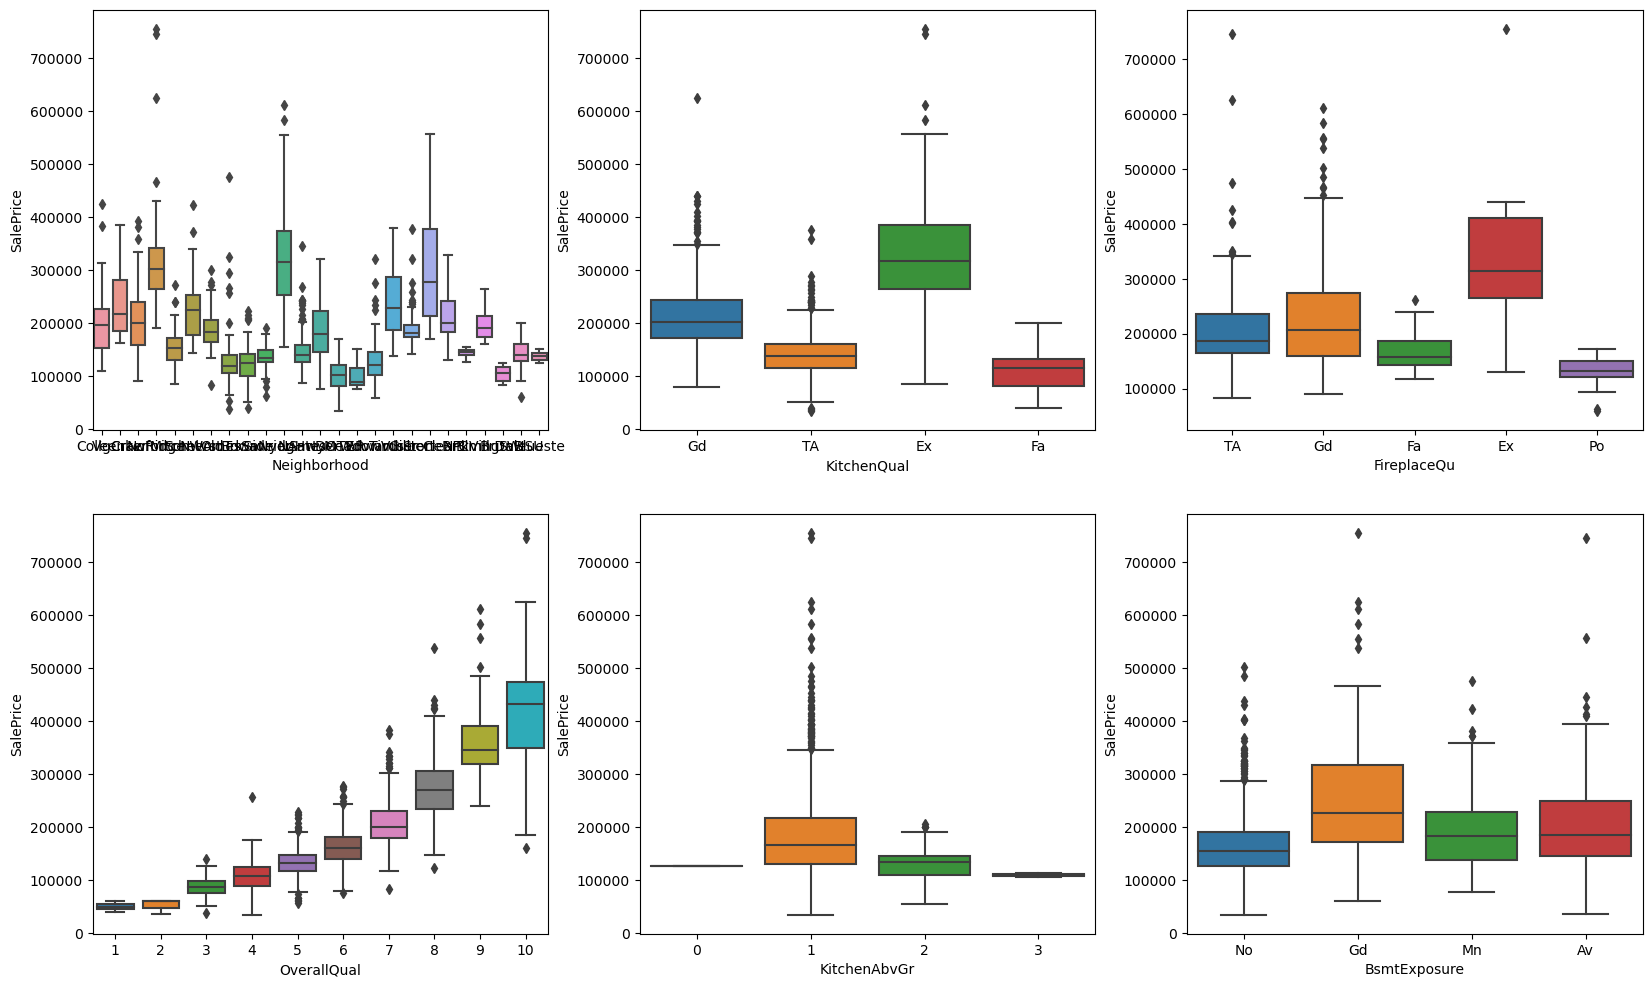

In [283]:
#Visualising Categorical Variables
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1) 
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = home_df)
plt.subplot(2,3,2)
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = home_df)
plt.subplot(2,3,3)
sns.boxplot(x = 'FireplaceQu', y = 'SalePrice', data = home_df)
plt.subplot(2,3,4)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = home_df)
plt.subplot(2,3,5)
sns.boxplot(x = 'KitchenAbvGr', y = 'SalePrice', data = home_df)
plt.subplot(2,3,6)
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = home_df)
plt.show()

### Data Cleaning

In [288]:
#Finding Columns Having Null Values 
home_df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head(10)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
dtype: float64

In [289]:
#finding & droping columns having missing values > 60%
home_df_most_null = list(home_df.columns[(home_df.isnull().sum()/len(home_df.index) * 100) > 60])
home_df_most_null.remove("Alley") #we can replace null with NA
home_df_most_null

['PoolQC', 'Fence', 'MiscFeature']

In [290]:
#Replecing the wrong values of features with the correct values from dictionary
home_df['MSZoning'] = home_df['MSZoning'].replace({'C (all)':'C'})
home_df['Neighborhood'] = home_df['Neighborhood'].replace({'NAmes':'Names'})
home_df['BldgType'] = home_df['BldgType'].replace({'2fmCon':'2FmCon', 'Duplex':'Duplx', 'Twnhs':'TwnhsE'}) 
home_df['Exterior2nd'] = home_df['Exterior2nd'].replace({'CmentBd':'CemntBd', 'Wd Shng':'Wd Sdng', 'Brk Cmn':'BrkComm'}) 
#null values for Alley featured filled with NA
home_df['Alley'].fillna('NA', inplace=True)
#MasVnrType, MasVnrArea with null values are to be filled with 'None' and '0.0' respectively
home_df['MasVnrType'].fillna('None', inplace=True)
home_df['MasVnrArea'].fillna(0.0, inplace=True)
#LotFrontage null values to be filled with 0.0
home_df['LotFrontage'].fillna(0.0, inplace=True)
#since Fireplaces 0, FireplaceQu feature will have value 'NA' 'No Fireplace'
home_df.loc[((home_df['Fireplaces'] == 0) & (home_df['FireplaceQu'].isnull())), 'FireplaceQu'] = 'NA'
#IF garage area 0 then garage built year = 0
home_df.loc[((home_df['GarageArea'] == 0) & (home_df['GarageYrBlt'].isnull())), 'GarageYrBlt'] = 0
#BsmtFinType2 filling mode value if BsmtFinSF2 is perially completed
modeValue = home_df.loc[((home_df['BsmtFinSF2'] > 0)),['BsmtFinType2']].BsmtFinType2.mode()
home_df.loc[((home_df['TotalBsmtSF'] > 0) & (home_df['BsmtFinSF2'] > 0) & (home_df['BsmtFinType2'].isnull()))
                       , ['BsmtFinType2']] = modeValue[0]
#Electrical filling single null value to mode value of the column
elect = home_df.Electrical.mode()
home_df.loc[home_df.Electrical.isnull(), ['Electrical']] = elect[0]

In [291]:
#cleaning features values depending on other features
basementfeatures = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
garagefeatures = ['GarageType','GarageFinish','GarageQual','GarageCond']
FillAllNulls = basementfeatures
FillAllNulls.extend(garagefeatures)
FillAllNulls = set(FillAllNulls) #will remove duplicate column name values if any
FillAllNulls = list(FillAllNulls)
#[home_df[col].fillna('NA', inplace=True) for col in ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2']] 
for col in FillAllNulls:
    if col in basementfeatures:
        #since total basement square feet 0, all the listed features will have value 'No Basement' 'NA'
        home_df.loc[((home_df['TotalBsmtSF'] == 0) & (home_df[col].isnull())), col] = 'NA'
        #When all square feets for basement are unfinshed then maximum times BsmtExposure has value 'No'
        home_df.loc[((home_df['BsmtUnfSF'] == home_df['TotalBsmtSF']) & (home_df['TotalBsmtSF'] > 0) & 
                     (home_df[col].isnull())), col] = 'No'
    if col in garagefeatures:
        #since GarageArea 0, all above features will have value 'NA' 'No Garage'
        home_df.loc[((home_df['GarageArea'] == 0) & (home_df[col].isnull())), col] = 'NA'

In [298]:
#Change data type 
if home_df.GarageYrBlt.dtype != int:
    home_df.GarageYrBlt = home_df.GarageYrBlt.astype(int)

In [299]:
#First creating filter so it will check column exist or not, while droping column not exists error will not come
dropFilter = home_df.filter(home_df_most_null)
home_df.drop(dropFilter, axis=1, inplace=True)
home_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [300]:
#Finding Columns Having Null Values 
home_df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head(10)

Id              0.0
FullBath        0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
KitchenAbvGr    0.0
BedroomAbvGr    0.0
HalfBath        0.0
BsmtHalfBath    0.0
dtype: float64

In [301]:
#checking any duplicate rows present
home_df.duplicated().any()

False

In [302]:
# head
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

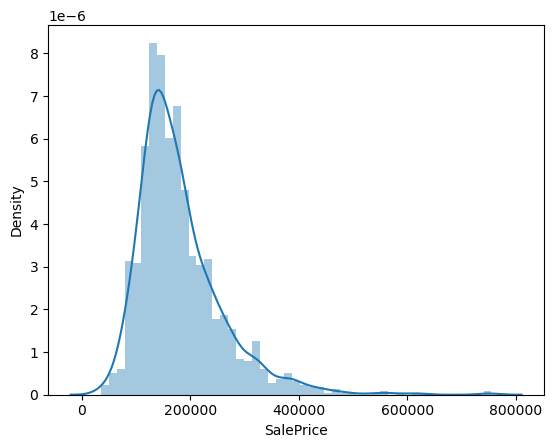

In [303]:
# target variable: price of house
sns.distplot(home_df['SalePrice'])
plt.show()

### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. 

In [304]:
#MSSubClass, OverallQual, OverallCond are actually is a categorical variable
home_df['MSSubClass'] = home_df['MSSubClass'].astype('str')
home_df['OverallQual'] = home_df['OverallQual'].astype('str')
home_df['OverallCond'] = home_df['OverallCond'].astype('str')

In [305]:
#We'll first subset the list of all (independent) numeric variables
numerical_fetures = home_df.select_dtypes(include=['float64', 'int64'])
numerical_fetures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   MasVnrArea     1460 non-null   float64
 6   BsmtFinSF1     1460 non-null   int64  
 7   BsmtFinSF2     1460 non-null   int64  
 8   BsmtUnfSF      1460 non-null   int64  
 9   TotalBsmtSF    1460 non-null   int64  
 10  1stFlrSF       1460 non-null   int64  
 11  2ndFlrSF       1460 non-null   int64  
 12  LowQualFinSF   1460 non-null   int64  
 13  GrLivArea      1460 non-null   int64  
 14  BsmtFullBath   1460 non-null   int64  
 15  BsmtHalfBath   1460 non-null   int64  
 16  FullBath       1460 non-null   int64  
 17  HalfBath       1460 non-null   int64  
 18  BedroomA

In [306]:
#we need to drop Id and MSSubClass features from numeric features list 
#as Id is a unique value and has no significantly related to othe variables 
numerical_fetures = numerical_fetures.drop(['Id'], axis=1)
numerical_fetures.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,192,84,0,0,0,0,0,12,2008,250000


In [307]:
# correlation matrix
cor = numerical_fetures.corr()
cor

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
LotFrontage,1.000000,0.100739,0.036853,0.078686,0.105010,0.076670,-0.009312,0.160829,0.238274,0.245181,...,-0.016780,0.069605,0.027366,0.023499,0.022969,0.114106,-0.059606,0.018942,-0.012094,0.209624
LotArea,0.100739,1.000000,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
YearBuilt,0.036853,0.014228,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.078686,0.013788,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.105010,0.103321,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,0.076670,0.214103,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.009312,0.111170,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,0.160829,-0.002618,0.149040,0.181133,0.113862,-0.495251,-0.209294,1.000000,0.415360,0.317987,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479
TotalBsmtSF,0.238274,0.260833,0.391452,0.291066,0.360067,0.522396,0.104810,0.415360,1.000000,0.819530,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581
1stFlrSF,0.245181,0.299475,0.281986,0.240379,0.339850,0.445863,0.097117,0.317987,0.819530,1.000000,...,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852


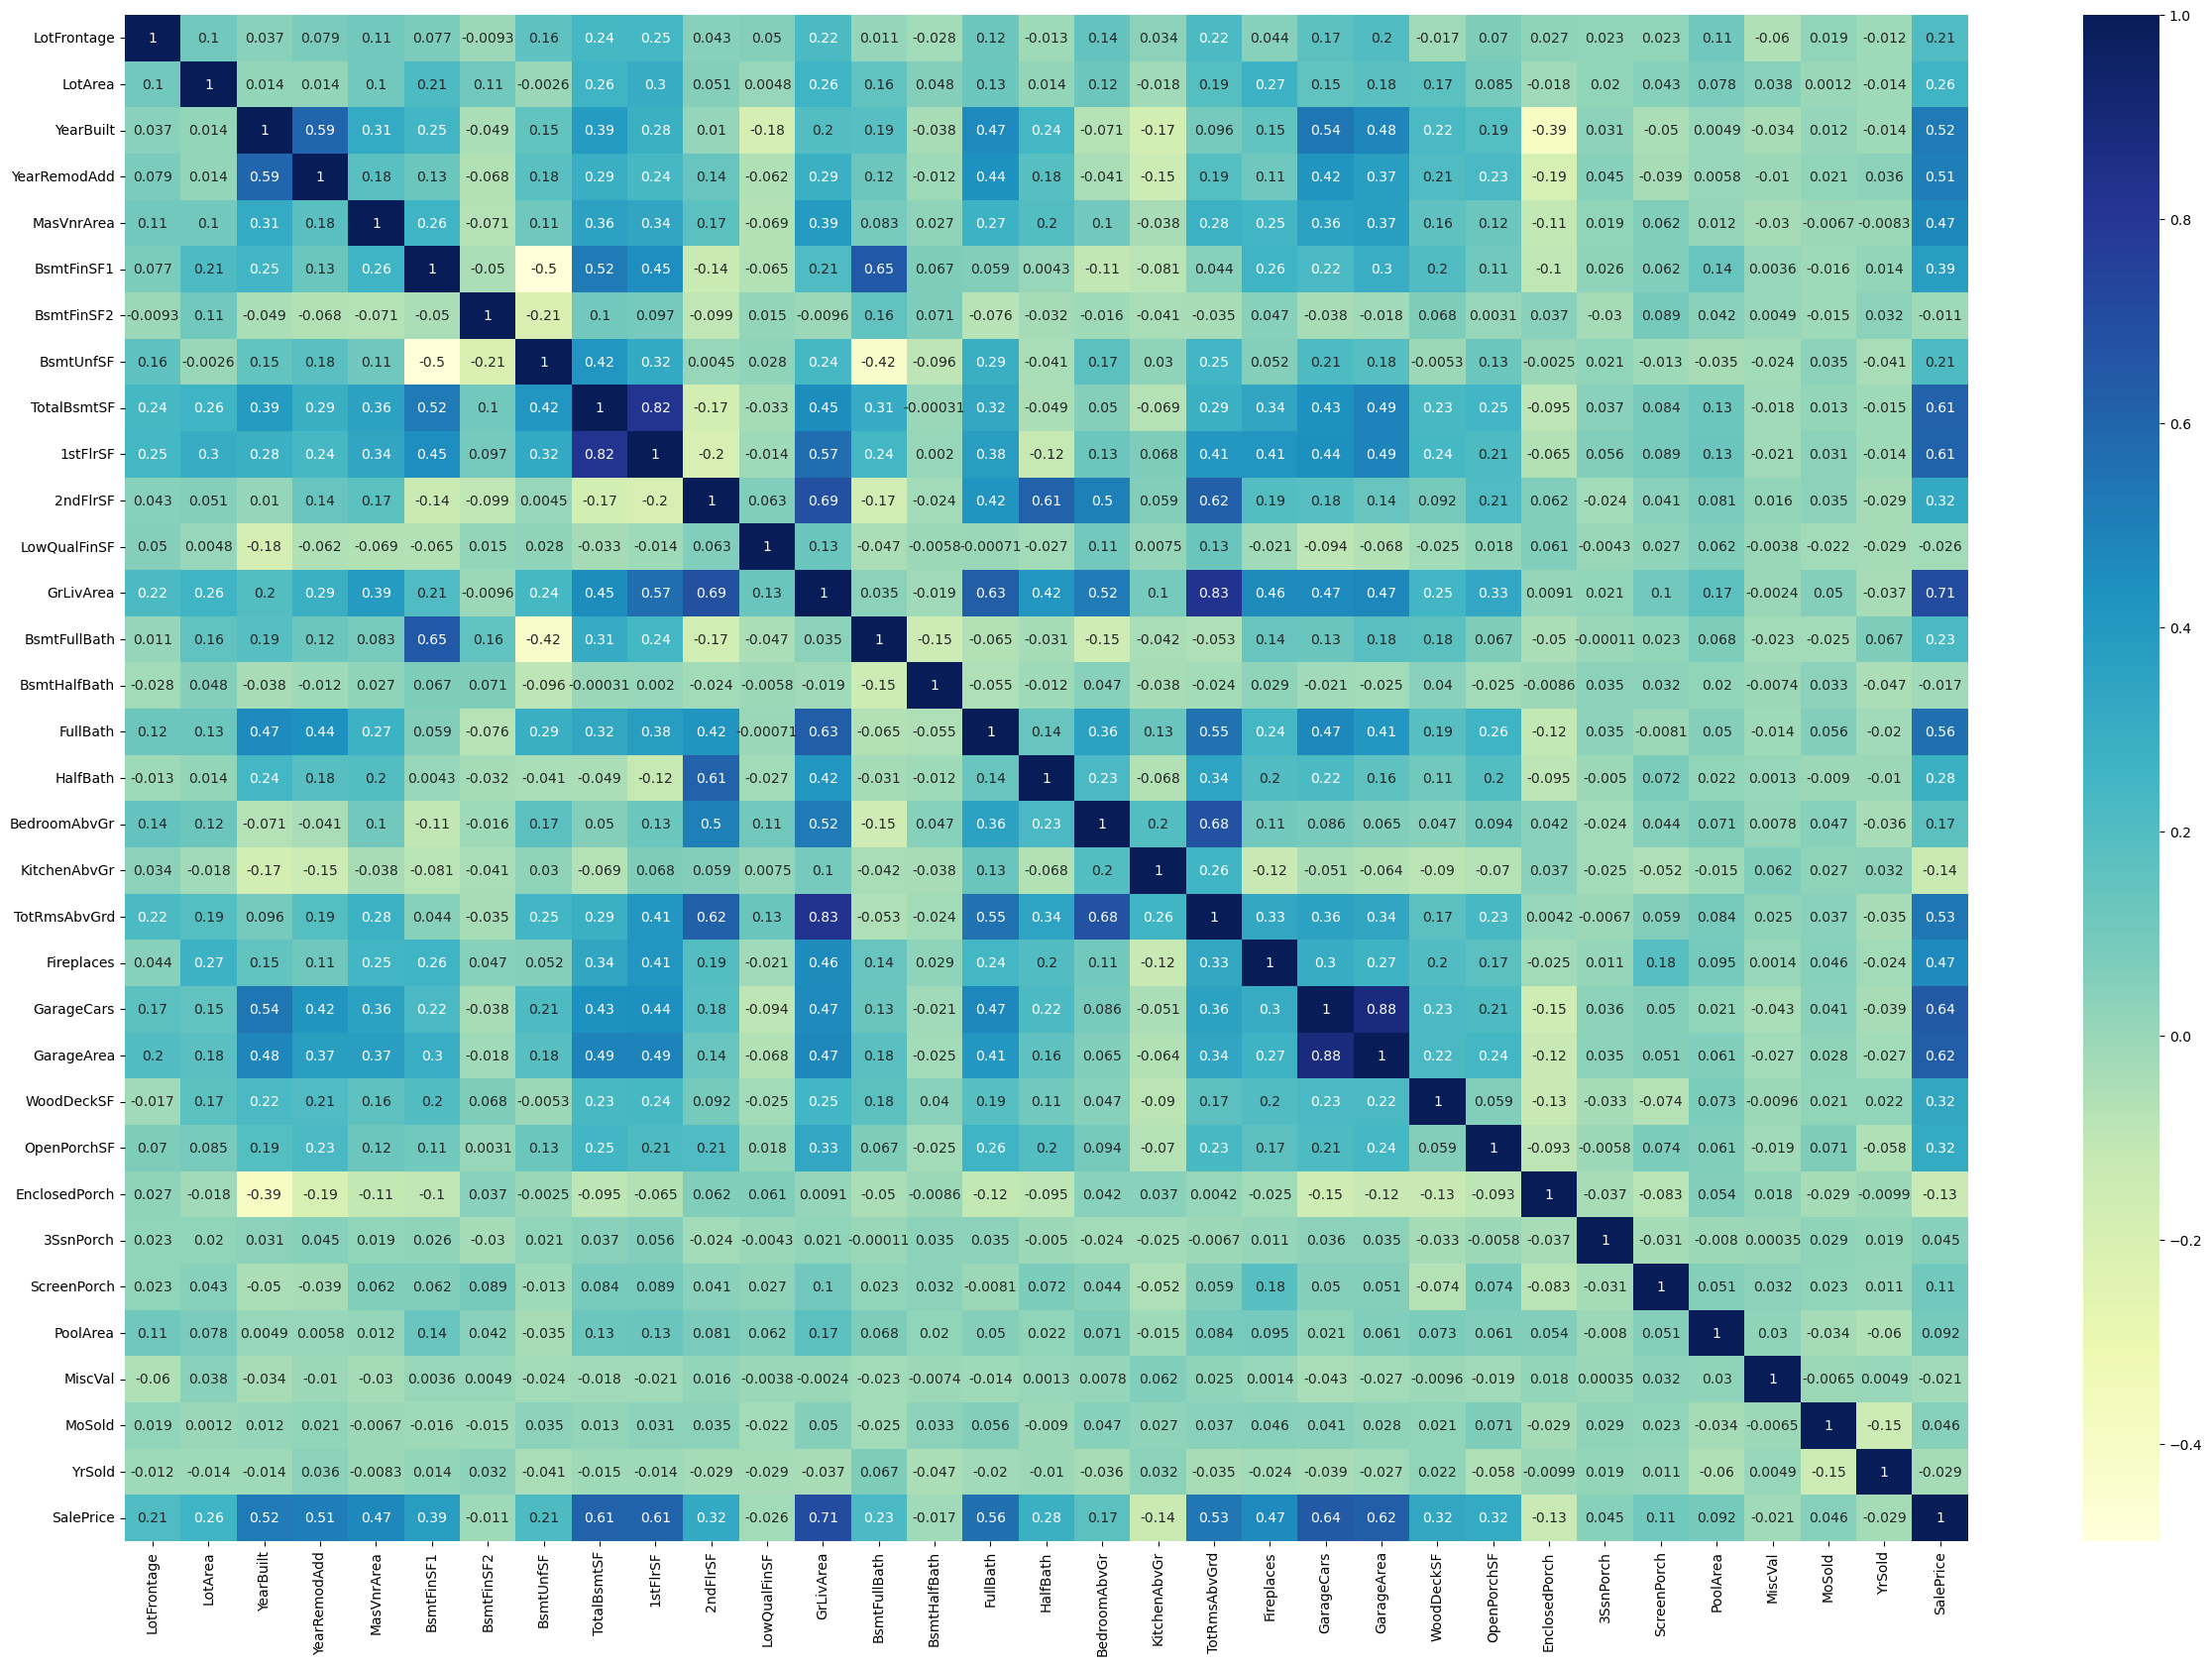

In [163]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

The heatmap shows some useful insights:

##### Correlation of price with independent variables:

House Sale Price is highly (positively) correlated with GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, fullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd, FirePlaces, MasVNrArea, BsmtFinSF1, WoodDeckSF, 
OpenPorchSF, 2ndFlrSF, HalfBath, LotArea, BsmtFullBath, LotFrontage, BsmtUnfSF, BedroomAbvGrd. 
Also features which are very less liked by the customers are ScreenPorch, 3SsnPorch, MoSold, PoolArea.

Houce Sale Price is negatively correlated to KitchenAbvGr, EnclosedPorch, BsmtFinSF2, BsmtHalfBath, MiscVal, LowQualFinSF, YrSold. This suggest that houses having kitchen above grade are mostly disliked by the customers, and are priced lower.


##### Correlation among independent variables:

Many independent variables are highly correlated. TotalBsmtSF, 1stFlrSF, TotalRmsAbvGr, GrLivArea etc are positively correlated.

### Data Preparation

Let's now prepare the data.

In [308]:
# split into X and y
y = home_df.pop('SalePrice') # response variable in Y
X = home_df # predictors in variable X

In [309]:
#Drop Id
dropFilter = X.filter(['Id'])
X.drop(dropFilter, axis=1, inplace=True)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal


In [310]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

In [311]:
# creating dummy variables for categorical variables

# subset all categorical variables
categorical_features = X.select_dtypes(include=['object'])
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   object
 15  OverallCond    1460 non-null   object
 16  RoofStyle      1460 non-null   object
 17  RoofMatl       1460 non-null   object
 18  Exterior1st    1460 non-null

In [312]:
# convert into dummies - one hot encoding
home_df_dummies = pd.get_dummies(categorical_features, drop_first=True)
home_df_dummies.head()

,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [313]:
# drop categorical variables 
#X = X.drop(list(categorical_features.columns), axis=1)
dropFilter = X.filter(list(categorical_features.columns))
X.drop(dropFilter, axis=1, inplace=True)

In [314]:
# concat dummy variables with X
X = pd.concat([X, home_df_dummies], axis=1)

In [315]:
X.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,0,1,0,0,0,1,0


In [316]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=278)

In [317]:
X.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.212877,-0.207142,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,0.645747,-0.091886,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,0.299451,0.073480,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,0.068587,-0.096897,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,0.761179,0.375148,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [318]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 2. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [175]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [176]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-199569423989651.4
[ 8.35769061e+02  7.04994698e+03  1.38668393e+04  1.75326329e+03
  2.73781892e+03  4.00108795e+15  1.41516181e+15  3.87624633e+15
 -3.84851115e+15 -1.08843796e+16 -1.22904602e+16 -1.36898309e+15
  1.47949028e+16  8.35500000e+02 -5.25625000e+01  8.28347656e+02
 -1.61956250e+03 -1.48931250e+03 -3.71243750e+03 -1.73065625e+03
  1.43050000e+03  1.09744375e+04  2.64300000e+03  2.77668750e+03
  6.52812500e+02  1.81137500e+03  5.72000000e+02  1.22275000e+03
  1.33375000e+03  3.74712500e+03  5.76875000e+02 -8.36281250e+02
 -3.73375000e+02 -1.26187500e+02 -1.99625000e+02 -3.18809849e+15
 -1.33053125e+03  2.34281250e+02  1.75156250e+02 -8.67625000e+02
 -1.30118750e+03  6.47812500e+02  2.95062500e+02 -3.11506250e+03
 -1.38276562e+03 -1.50250000e+03 -9.65764271e+14  7.75018750e+03
  4.17118750e+03  1.61053438e+04  1.26237500e+04  1.57868750e+03
  5.44312500e+02  2.94031250e+02  3.96562500e+02  5.93375000e+02
  2.11187500e+02 -5.67000000e+02 -1.19806250e+03  8.14500000e+02
 -3.48

In [177]:
from sklearn.metrics import r2_score, mean_squared_error

In [178]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9569161787029803
-8.05901679608141e+21
274904886826.7783
2.271605162541836e+34
269250623.7284802
5.18631315648821e+31


##### With above r2 values we clearly understand that model is performing significantly on the training set but on training set it failed to perform. This problem is due to overfitting. Lets see Ridge and Lasso regression helps us to come out of the overfitting problem.

## Ridge and Lasso Regression

Let's now try predicting House prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [319]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [320]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [321]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 1.60894120e+02  2.76523235e+03  1.99389775e+03  3.06618229e+03
  3.28577703e+03  2.14954763e+03  8.91957410e+02  8.19654134e+02
  3.38831667e+03  5.17065547e+03  4.77633754e+03 -4.64089796e+02
  7.72883977e+03  2.34080992e+03  1.92638859e+02  4.18673983e+03
  2.02211322e+03  7.12412307e+02 -1.83677096e+03  3.93659801e+03
  2.70969854e+03  1.09230208e+01  4.47218441e+03  3.13299377e+03
  1.57269879e+03  9.89737160e+02  1.41386503e+02  1.13459433e+03
  1.25773371e+03 -2.60919897e+02  1.28760678e+02 -2.50236739e+02
 -4.48213445e+02 -1.35950132e+03 -5.83104678e+02 -9.33185273e+02
  1.49823533e+03 -7.22134044e+02  1.84364503e+02  1.43429829e+02
  4.60569101e+02  7.62927283e+02  7.97955499e+02  3.34164532e+02
 -6.82065717e+02 -2.00235231e+02 -7.44165112e+02  7.48665342e+02
  2.75996561e+02  1.16488191e+03 -7.63103623e+02  6.98312952e+02
  3.38438159e+02  5.35082967e+02  4.85715069e+02 -2.03754996e+03
 -4.70951000e+02  1.00688921e+03  5.15392875e+02  1.57458713e+03
 -9.02896111e+02  1.96286

In [323]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8936641677004936
0.862558947239897
678496917494.8549
387406817599.4418
664541545.0488294
884490451.140278


## Lasso

In [324]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [325]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [326]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised

alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [327]:
lasso.coef_

array([-0.00000000e+00,  3.94263961e+03,  8.32262684e+03,  3.66213298e+03,
        1.49760345e+03,  2.33378305e+03,  5.19173680e+01, -0.00000000e+00,
        3.69895833e+03,  0.00000000e+00,  0.00000000e+00, -1.98194452e+03,
        3.03497537e+04,  2.81367393e+03,  0.00000000e+00,  2.22278711e+03,
        0.00000000e+00, -7.60013945e+02, -4.73392091e+03,  0.00000000e+00,
        3.40963945e+02, -0.00000000e+00,  5.97257370e+03,  0.00000000e+00,
        3.67429540e+02,  3.40160471e+02,  0.00000000e+00,  8.29067693e+02,
        1.22720898e+03, -0.00000000e+00,  0.00000000e+00, -9.74856587e+01,
       -0.00000000e+00, -1.44533218e+03, -0.00000000e+00, -6.19178435e+02,
        2.48985395e+03,  0.00000000e+00,  2.21426963e+02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -1.02003327e+02,  0.00000000e+00,
        0.00000000e+00,  1.02625797e+03, -0.00000000e+00,  9.45785306e+02,
        0.00000000e+00,  

In [328]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9322771190403039
0.8475354701397759
432119305236.66144
429753680750.98413
423231444.8938897
981172787.1027035


In [329]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.569162e-01,8.936642e-01,9.322771e-01
1,R2 Score (Test),-8.059017e+21,8.625589e-01,8.475355e-01
2,RSS (Train),2.749049e+11,6.784969e+11,4.321193e+11
3,RSS (Test),2.271605e+34,3.874068e+11,4.297537e+11
4,MSE (Train),1.640886e+04,2.577870e+04,2.057259e+04
5,MSE (Test),7.201606e+15,2.974038e+04,3.132368e+04


## Lets observe the changes in the coefficients after regularization

In [330]:
betas = pd.DataFrame(index=X.columns)

In [331]:
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Linear,Ridge,Lasso
LotFrontage,8.357691e+02,160.894120,-0.000000e+00
LotArea,7.049947e+03,2765.232353,3.942640e+03
YearBuilt,1.386684e+04,1993.897754,8.322627e+03
YearRemodAdd,1.753263e+03,3066.182293,3.662133e+03
MasVnrArea,2.737819e+03,3285.777033,1.497603e+03
BsmtFinSF1,4.001088e+15,2149.547627,2.333783e+03
BsmtFinSF2,1.415162e+15,891.957410,5.191737e+01
BsmtUnfSF,3.876246e+15,819.654134,-0.000000e+00
TotalBsmtSF,-3.848511e+15,3388.316675,3.698958e+03
1stFlrSF,-1.088438e+16,5170.655474,0.000000e+00


## Subject Questions Answers

##### Question 1

##### Ridge

In [332]:
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised
alpha1 = 1000
ridge1 = Ridge(alpha=alpha1)

ridge1.fit(X_train, y_train)
print(ridge1.coef_)

[  608.72208363  2300.49940005  1693.88595322  2786.29307443
  3230.0268562   2361.25074028   667.81186101   870.12533697
  3576.82577419  4689.59506361  3600.87474546  -300.0095944
  6413.63004939  1997.88953171   130.38058581  3593.70466982
  1908.87630122   905.91966585 -1393.16019485  3819.56441877
  2822.50973527   142.91913938  3857.0622327   3319.82292732
  1768.56064064  1106.1629763     73.40115439   901.69981094
  1034.22820725    69.41305567    74.85325294  -169.07017557
  -325.25117215 -1214.02753193  -541.38007294  -758.28957189
   954.67241926  -895.72256657   151.61599439    96.06096481
   257.53102117  1163.20809974   749.62621055   209.43616691
  -635.3960634   -249.28475617  -697.37183113   636.25554361
   167.90217226  1055.82293194 -1022.61998195   547.98890611
   363.73555187   291.14153145   511.80291421 -1550.86321319
  -785.15845152   842.06343184   487.29340047   884.67215845
  -714.99796494  1636.2450146   -802.09875027  -213.47932375
  -458.88072987   610.928

In [333]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge1.predict(X_train)
y_pred_test = ridge1.predict(X_test)

metric21 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric21.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric21.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric21.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric21.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric21.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric21.append(mse_test_lr**0.5)

0.870132090410631
0.8515556261582596
828648014807.4832
418422016607.7207
811604324.0034115
955301407.7801843


##### Lasso

In [334]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha1 = 1000
lasso1 = Lasso(alpha=alpha1)
lasso1.fit(X_train, y_train) 

Lasso(alpha=1000)

In [335]:
lasso1.coef_

array([-0.00000000e+00,  3.37695598e+03,  5.98856616e+03,  4.28611542e+03,
        9.42447186e+02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.32866708e+03,  0.00000000e+00,  0.00000000e+00, -1.33635557e+03,
        2.85815637e+04,  3.09190670e+03,  0.00000000e+00,  2.48819075e+03,
        0.00000000e+00, -0.00000000e+00, -4.45093053e+03,  0.00000000e+00,
        1.01312206e+02, -0.00000000e+00,  7.43717868e+03,  0.00000000e+00,
        1.23416026e+02,  0.00000000e+00,  0.00000000e+00,  5.44432915e+02,
        1.10445082e+03, -1.31506776e+03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.36664256e+03, -0.00000000e+00, -2.41353465e+02,
        3.47214368e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.94056652e+02, -0.00000000e+00,  4.01952284e+02,
        0.00000000e+00,  

In [336]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso1.predict(X_train)
y_pred_test = lasso1.predict(X_test)

metric31 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric31.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric31.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric31.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric31.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric31.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric31.append(mse_test_lr**0.5)

0.8993171045075061
0.8432697516215422
642427230396.8306
441777514989.277
629213741.8186392
1008624463.4458379


In [337]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric1 = pd.Series(metric21, name = 'Ridge Regression')
ls_metric1 = pd.Series(metric31, name = 'Lasso Regression')

final_metric1 = pd.concat([lr_metric, rg_metric1, ls_metric1], axis = 1)

final_metric1

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.569162e-01,8.701321e-01,8.993171e-01
1,R2 Score (Test),-8.059017e+21,8.515556e-01,8.432698e-01
2,RSS (Train),2.749049e+11,8.286480e+11,6.424272e+11
3,RSS (Test),2.271605e+34,4.184220e+11,4.417775e+11
4,MSE (Train),1.640886e+04,2.848867e+04,2.508413e+04
5,MSE (Test),7.201606e+15,3.090795e+04,3.175885e+04


In [338]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge1.coef_
betas['Lasso'] = lasso1.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Linear,Ridge,Lasso
LotFrontage,8.357691e+02,608.722084,-0.000000
LotArea,7.049947e+03,2300.499400,3376.955984
YearBuilt,1.386684e+04,1693.885953,5988.566162
YearRemodAdd,1.753263e+03,2786.293074,4286.115417
MasVnrArea,2.737819e+03,3230.026856,942.447186
BsmtFinSF1,4.001088e+15,2361.250740,0.000000
BsmtFinSF2,1.415162e+15,667.811861,0.000000
BsmtUnfSF,3.876246e+15,870.125337,-0.000000
TotalBsmtSF,-3.848511e+15,3576.825774,1328.667083
1stFlrSF,-1.088438e+16,4689.595064,0.000000


### Question 3

In [339]:
#'GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'
dropFilter = X_train.filter(['GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'])
X_train.drop(dropFilter, axis=1, inplace=True)
X_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.270593,-0.492374,-1.532424,-1.689368,-0.570750,0.053428,-0.288653,-0.387671,-0.441061,-0.772733,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
318,0.934327,-0.061820,0.719786,0.394133,0.846202,1.191731,-0.288653,-0.469172,0.660283,0.541779,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
239,-0.162277,-0.177977,-0.870009,-1.689368,-0.570750,-0.766852,-0.288653,0.166984,-0.735209,-0.943516,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
986,0.039729,-0.521839,-2.029235,0.878668,-0.570750,-0.973018,-0.288653,-0.186184,-1.305262,-0.418229,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1416,0.068587,0.082500,-2.857254,-1.689368,-0.570750,-0.973018,-0.288653,0.474875,-0.639440,0.215738,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [340]:
#'GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'
dropFilter = X_test.filter(['GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'])
X_test.drop(dropFilter, axis=1, inplace=True)
X_test.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.068587,-0.152020,-0.008870,-0.671845,-0.570750,0.378031,-0.288653,-0.722728,-0.441061,-0.772733,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
57,0.905469,0.113068,1.084115,0.927122,-0.570750,-0.973018,-0.288653,0.662778,-0.450182,-0.783083,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
780,0.155161,-0.264769,0.786028,0.539493,-0.360421,-0.973018,-0.288653,1.516269,0.409460,0.233852,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
382,0.616889,-0.127465,1.150356,1.024029,-0.570750,-0.973018,-0.288653,0.841627,-0.270045,-0.578661,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1170,0.530315,-0.063824,0.189854,-0.381123,-0.570750,0.171865,-0.288653,0.015303,0.087949,-0.115477,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [341]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha2 = 1000
lasso2 = Lasso(alpha=alpha2)
lasso2.fit(X_train, y_train) 
lasso2.coef_

array([-0.00000000e+00,  2.89540054e+03,  7.17327425e+03,  5.15995905e+03,
        2.55526268e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.90286722e+03,  1.98651268e+04,  2.32987654e+04, -0.00000000e+00,
        2.35037891e+03,  0.00000000e+00,  3.50101976e+03,  7.68345353e+01,
       -0.00000000e+00, -5.39316232e+03,  9.02958555e+02,  2.02116807e+03,
        0.00000000e+00,  5.22308502e+03,  1.04215509e+03,  0.00000000e+00,
       -0.00000000e+00,  1.65367102e+02,  8.23524126e+02, -8.91674380e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.36060351e+03,
       -0.00000000e+00, -3.59546337e+02,  2.34023956e+03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.56547088e+02,
       -0.00000000e+00,  4.65952543e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [342]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso2.predict(X_train)
y_pred_test = lasso2.predict(X_test)

metric33 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric33.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric33.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric33.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric33.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric33.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric33.append(mse_test_lr**0.5)

0.8889095796746465
0.839000213558702
708834511603.386
453812115425.812
694255153.3823565
1036100720.1502557


In [343]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Lasso'] = lasso2.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Lasso
LotFrontage,-0.000000
LotArea,2895.400538
YearBuilt,7173.274254
YearRemodAdd,5159.959053
MasVnrArea,2555.262676
BsmtFinSF1,0.000000
BsmtFinSF2,0.000000
BsmtUnfSF,0.000000
TotalBsmtSF,4902.867218
1stFlrSF,19865.126819
